In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split

fig_dpi = 200

%load_ext tensorboard

# Neural Network Training


## Load Dataset

In [2]:
data = pd.read_csv('features.csv', header=None).T
data.columns = ['Clump thickness', 'Uniformity of cell size', 'Uniformity of cell shape', 'Marginal adhesion', 'Single epithelial cell size', 'Bare nuclei', 'Bland chomatin', 'Normal nucleoli', 'Mitoses']
labels = pd.read_csv('targets.csv', header=None).T
labels.columns = ['Benign', 'Malignant']
data.describe()

,Clump thickness,Uniformity of cell size,Uniformity of cell shape,Marginal adhesion,Single epithelial cell size,Bare nuclei,Bland chomatin,Normal nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,0.441774,0.313448,0.320744,0.280687,0.321602,0.354363,0.343777,0.286695,0.158941
std,0.281574,0.305146,0.297191,0.285538,0.221430,0.360186,0.243836,0.305363,0.171508
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.200000,0.100000,0.100000,0.100000,0.200000,0.100000,0.200000,0.100000,0.100000
50%,0.400000,0.100000,0.100000,0.100000,0.200000,0.100000,0.300000,0.100000,0.100000
75%,0.600000,0.500000,0.500000,0.400000,0.400000,0.500000,0.500000,0.400000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
labels.head()

,Benign,Malignant
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0


### Explore Dataset

In [4]:
labels.astype(bool).sum(axis=0)

Benign       458
Malignant    241
dtype: int64

## Split Dataset

Using a 50/50 split, maybe use stratification?

In [5]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, random_state=70, stratify=labels)

## Generate & Retrieve Model

In [6]:
def get_model(hidden_layers=2, activation='sigmoid'):
    layers = [tf.keras.layers.InputLayer(input_shape=(9,))] + [
        tf.keras.layers.Dense(9, activation=activation)
        for _ in range(hidden_layers - 1)
    ] + [tf.keras.layers.Dense(2, activation='softmax')]

    model = tf.keras.models.Sequential(layers)
    return model

# Example Training

## Define Model

Variable number of hidden layers. All using 9D outputs except the last layer which is 2D for binary classification

In [7]:
hidden_layers = 9

model = get_model(hidden_layers)
model.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 9

## Train Model

Example 10 epochs

In [8]:
model.fit(data_train, labels_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 3s 3ms/step - loss: 0.8853 - accuracy: 0.3177
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.7855 - accuracy: 0.3336
Epoch 3/10
11/11 [==============================] - 0s 3ms/step - loss: 0.7236 - accuracy: 0.3635
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4511
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.6226
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6577
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.6214
Epoch 8/10
11/11 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6349
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6702
Epoch 10/10
11/11 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6493


In [9]:
model.metrics_names

['loss', 'accuracy']

In [10]:
model.metrics[1].result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6561605>

# Experiment 1

The below function runs an iteration of layer/epoch investigations.
Returns the amount of layers/epochs used as well as the results and the model.

In [11]:
hidden_layers = [2, 5, 8, 12, 16, 24, 32]
epochs = [1, 2, 4, 8, 16, 32, 64]

def evaluate_parameters(hidden_layers = hidden_layers, 
                        epochs = epochs, 
                        batch_size=128,
                        optimizer='sgd',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'],

                        verbose=0,
                        print_params=True,
                        return_model=True,
                        
                        data_train=data_train,
                        data_test=data_test,
                        labels_train=labels_train,
                        labels_test=labels_test):
    for idx1, hl in enumerate(hidden_layers):
        for idx2, e in enumerate(epochs):
            if print_params:
                print(f"Layers: {hl}, Epochs: {e}")

            model = get_model(hl)
            model.compile(
                optimizer = optimizer,
                loss=loss,
                metrics=metrics
                )
            model.fit(data_train, labels_train, epochs=e, verbose=verbose)

            response = {"layers": hl, 
                        "epochs": e, 
                        "results": model.evaluate(data_test, 
                                                  labels_test, 
                                                  batch_size=batch_size, 
                                                  verbose=verbose)}

            if return_model:
                response["model"] = model

            yield response

Run a single iteration of epoch/layer investigations

In [12]:
single_results = list(evaluate_parameters(return_model=False))

Layers: 2, Epochs: 1
Layers: 2, Epochs: 2
Layers: 2, Epochs: 4
Layers: 2, Epochs: 8
Layers: 2, Epochs: 16
Layers: 2, Epochs: 32
Layers: 2, Epochs: 64
Layers: 5, Epochs: 1
Layers: 5, Epochs: 2
Layers: 5, Epochs: 4
Layers: 5, Epochs: 8
Layers: 5, Epochs: 16
Layers: 5, Epochs: 32
Layers: 5, Epochs: 64
Layers: 8, Epochs: 1
Layers: 8, Epochs: 2
Layers: 8, Epochs: 4
Layers: 8, Epochs: 8
Layers: 8, Epochs: 16
Layers: 8, Epochs: 32
Layers: 8, Epochs: 64
Layers: 12, Epochs: 1
Layers: 12, Epochs: 2
Layers: 12, Epochs: 4
Layers: 12, Epochs: 8
Layers: 12, Epochs: 16
Layers: 12, Epochs: 32
Layers: 12, Epochs: 64
Layers: 16, Epochs: 1
Layers: 16, Epochs: 2
Layers: 16, Epochs: 4
Layers: 16, Epochs: 8
Layers: 16, Epochs: 16
Layers: 16, Epochs: 32
Layers: 16, Epochs: 64
Layers: 24, Epochs: 1
Layers: 24, Epochs: 2
Layers: 24, Epochs: 4
Layers: 24, Epochs: 8
Layers: 24, Epochs: 16
Layers: 24, Epochs: 32
Layers: 24, Epochs: 64
Layers: 32, Epochs: 1
Layers: 32, Epochs: 2
Layers: 32, Epochs: 4
Layers: 32, E

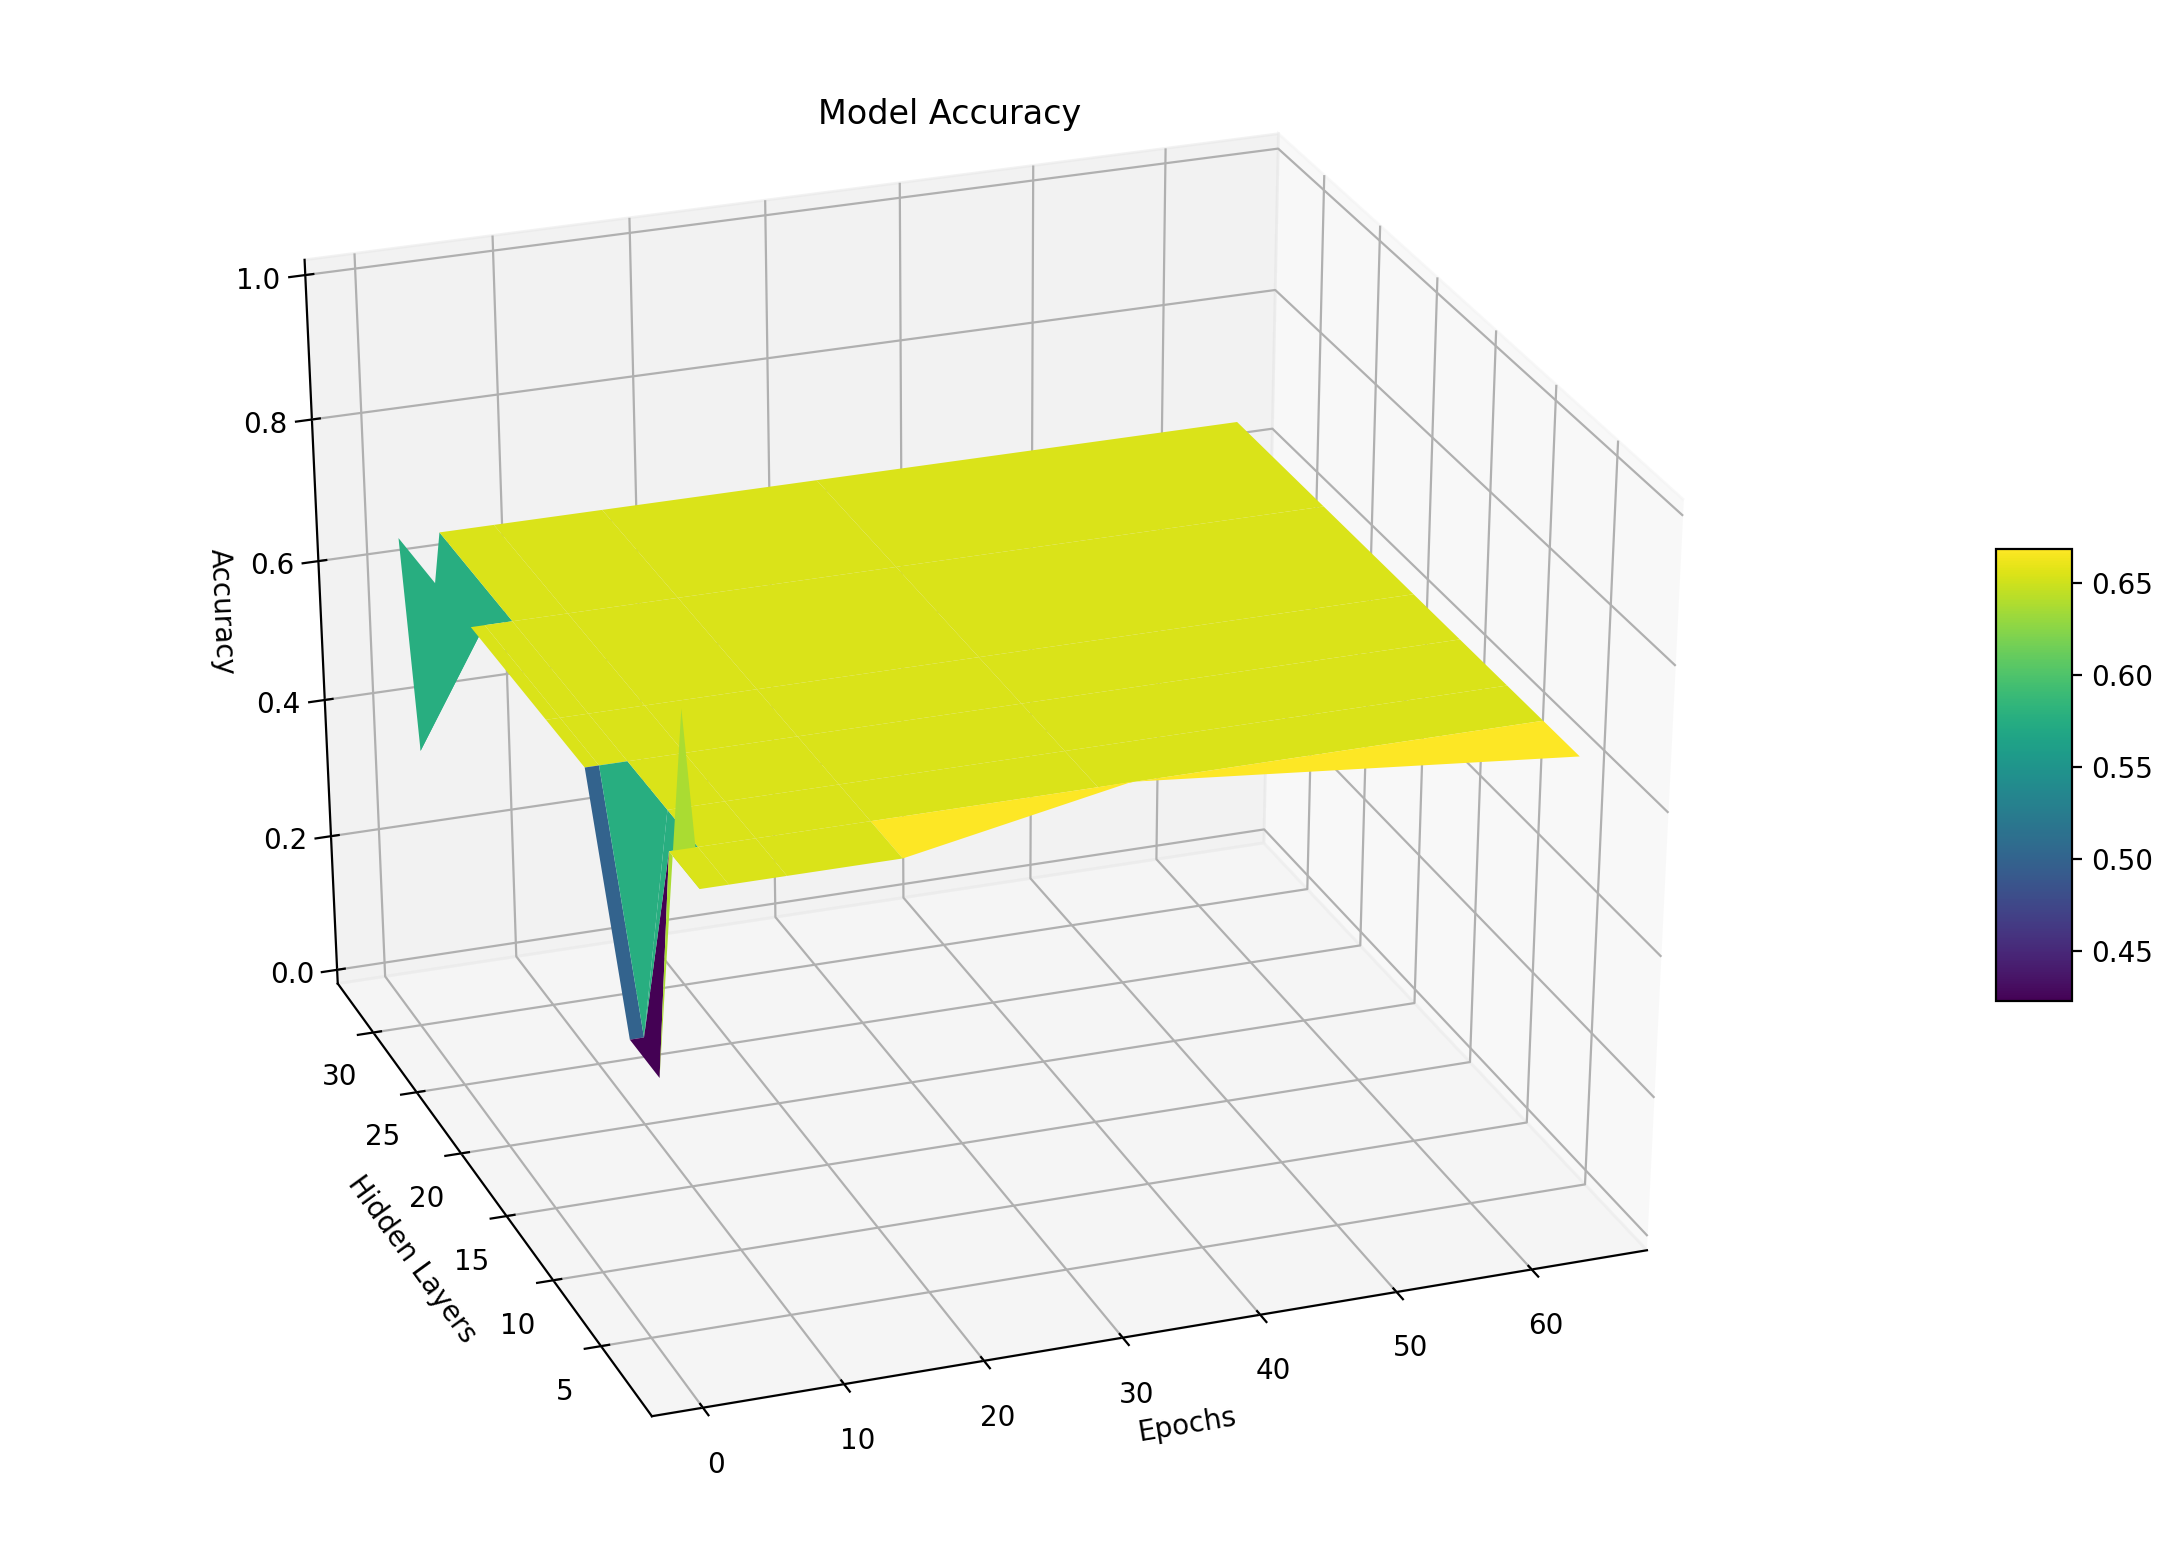

In [13]:
X, Y = np.meshgrid(epochs, hidden_layers)

shaped_result = np.reshape([r["results"][1] for r in single_results], 
                           (len(hidden_layers), len(epochs)))

fig = plt.figure(figsize=(15, 10))
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, shaped_result, cmap='viridis')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Layers')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.show()

In [14]:
multi_results = list()
multi_iterations = 30
for i in range(multi_iterations):
    print(f"Iteration {i+1}/{multi_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, stratify=labels)
    multi_results.append(list(evaluate_parameters(data_train=data_train, 
                                                  data_test=data_test, 
                                                  labels_train=labels_train, 
                                                  labels_test=labels_test,
                                                  return_model=False,
                                                  print_params=False)))

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Iteration 21/30
Iteration 22/30
Iteration 23/30
Iteration 24/30
Iteration 25/30
Iteration 26/30
Iteration 27/30
Iteration 28/30
Iteration 29/30
Iteration 30/30


In [15]:
average_accuracy = np.zeros((len(epochs), len(hidden_layers)))
for iteration in multi_results:
    for single_test in iteration: 
        average_accuracy[epochs.index(single_test['epochs']), hidden_layers.index(single_test['layers'])] += single_test["results"][1]

average_accuracy = average_accuracy / len(multi_results)

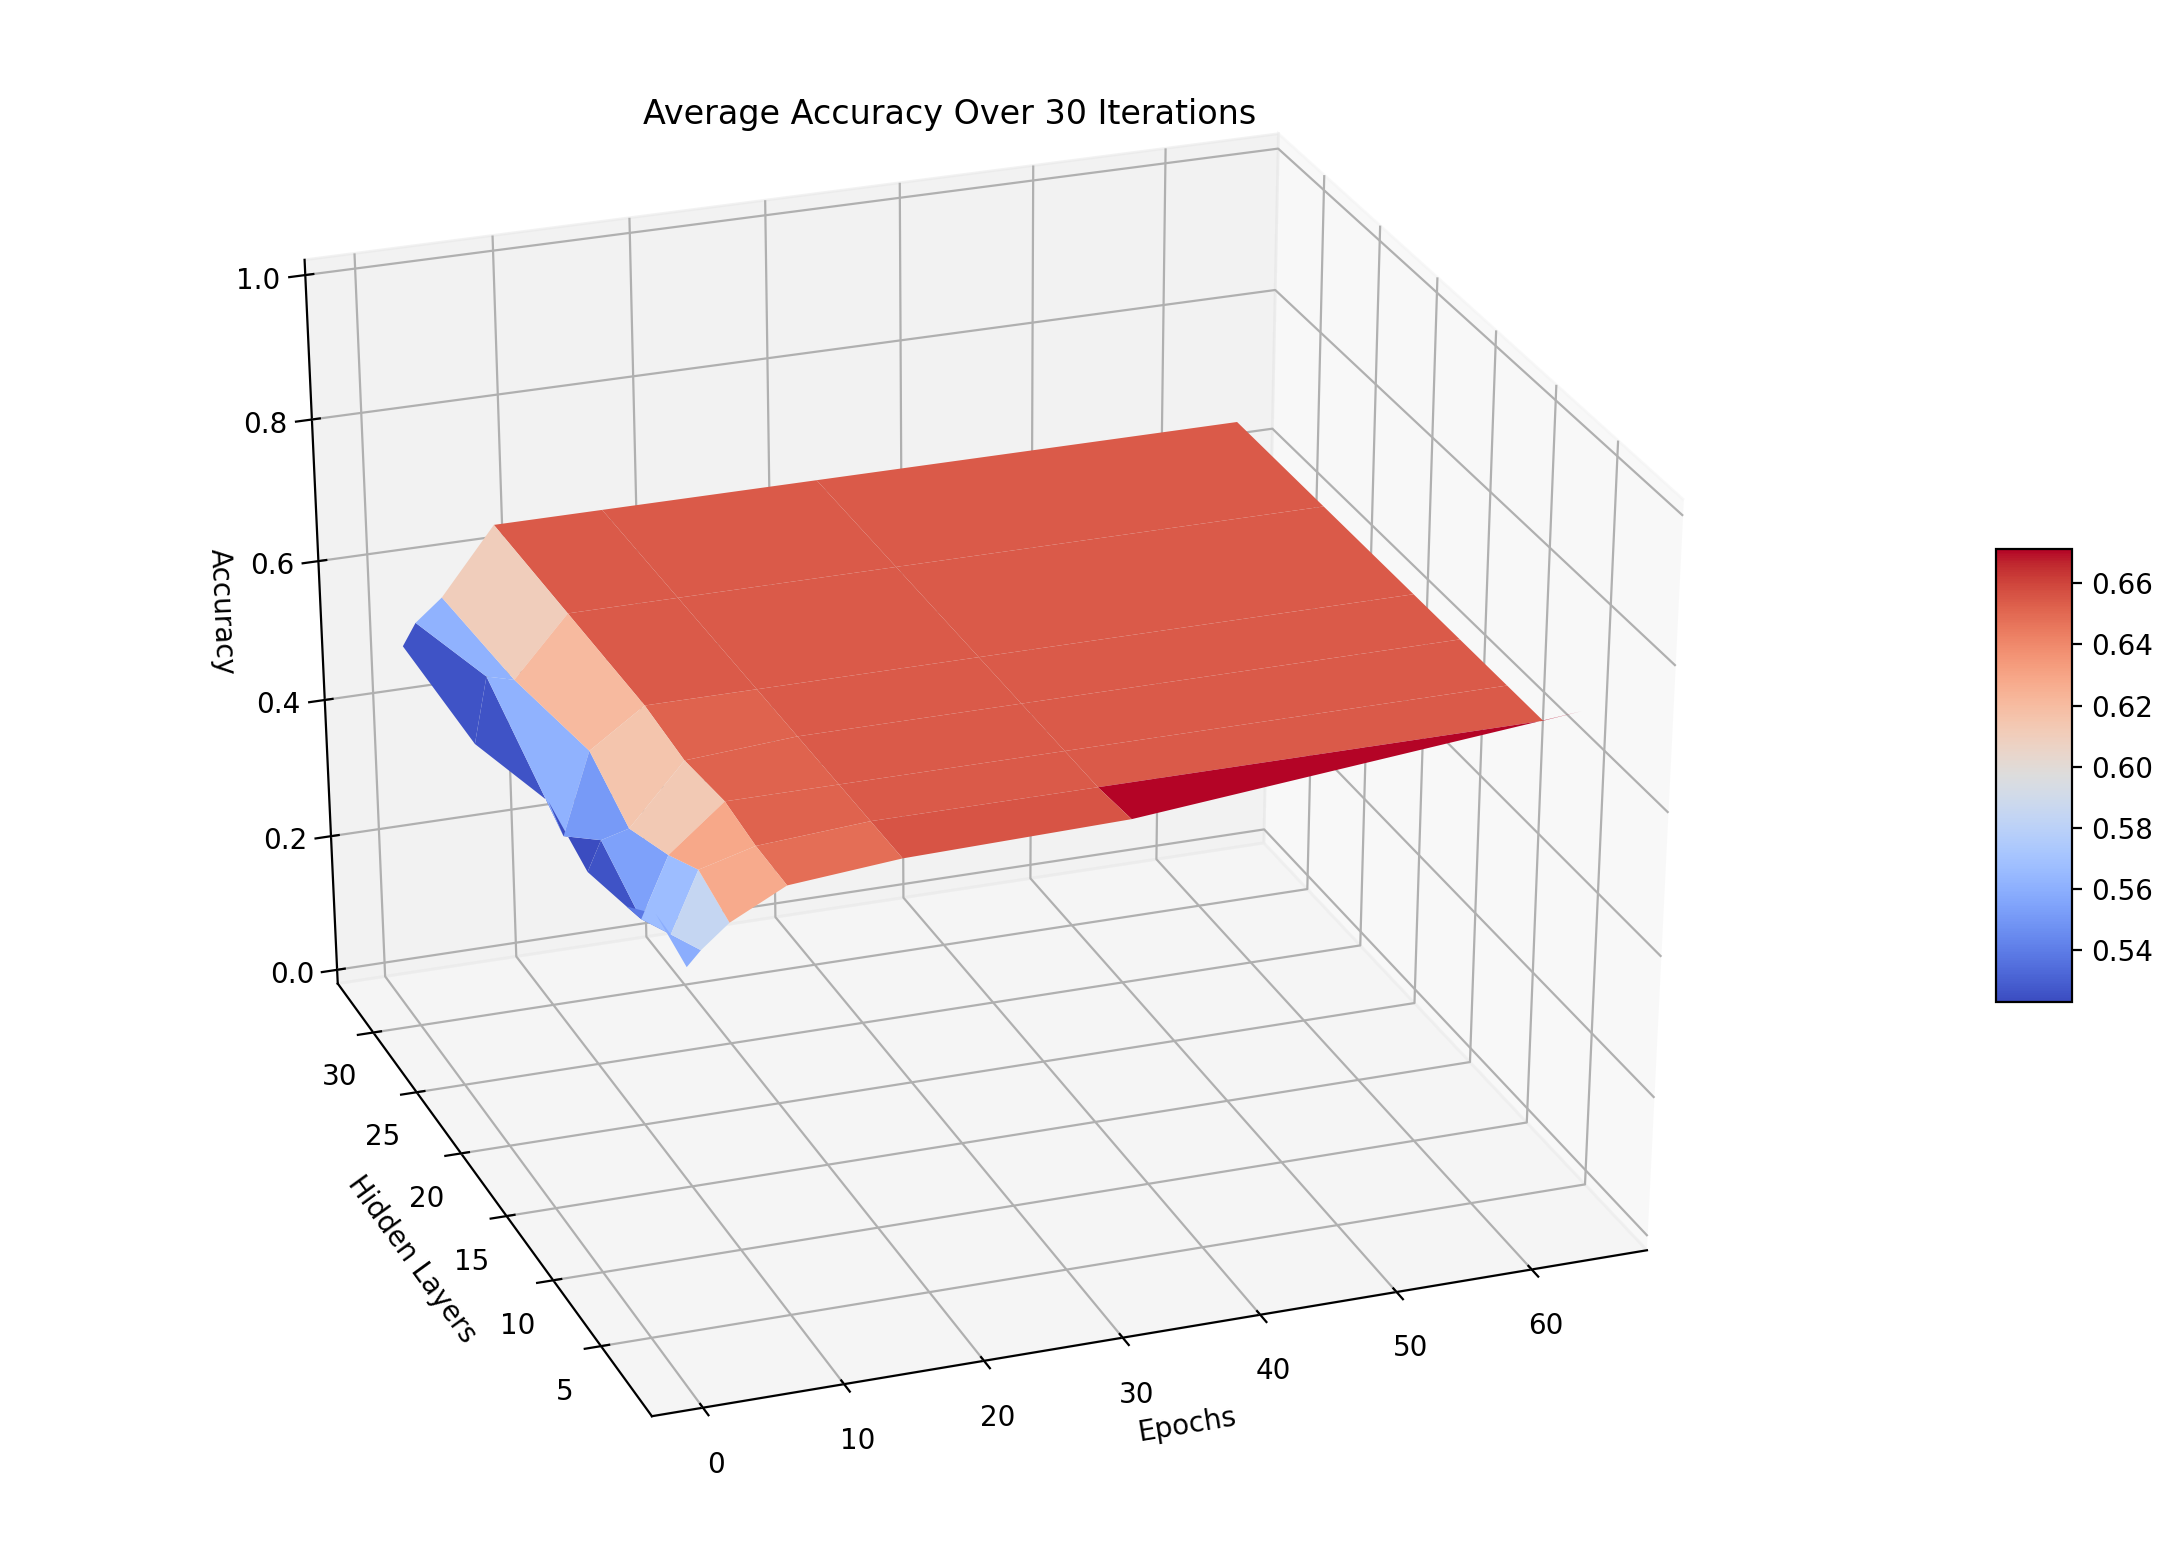

In [16]:
X, Y = np.meshgrid(epochs, hidden_layers)

fig = plt.figure(figsize=(15, 10))
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, average_accuracy.T, cmap='coolwarm')
ax.set_title(f'Average Accuracy Over {multi_iterations} Iterations')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Layers')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.show()

# Experiment 2

# Experiment 3